In [1]:
!pip install pandas
!pip install scikit-learn 
!pip install openpyxl
!pip install matplotlib 
!pip install seaborn 
!pip install numpy 
!pip install statsmodels
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")



Чтение и аналииз данных

In [2]:
test = pd.read_excel("test.xlsx")  
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                28 non-null     datetime64[ns]
 1   Цена на арматуру  28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes


In [3]:
test.describe()

,dt,Цена на арматуру
count,28,28.000000
mean,2022-12-08 12:00:00,44250.000000
min,2022-09-05 00:00:00,40000.000000
25%,2022-10-22 06:00:00,41925.000000
50%,2022-12-08 12:00:00,42900.000000
75%,2023-01-24 18:00:00,45625.000000
max,2023-03-13 00:00:00,55500.000000
std,NaN,3645.951585


In [4]:
 # Преобразуем колонку с датой в формат datetime
test['dt'] = pd.to_datetime(test['dt'])

# Убеждаемся, что данные отсортированы по времени
test = test.sort_values(by='dt')


# Добавляем новые признаки
test["year"] = test["dt"].dt.year
test["month"] = test["dt"].dt.month
test["quarter"] = test["dt"].dt.quarter
test["day_of_month"] = test["dt"].dt.day
test["day_of_week"] = test["dt"].dt.weekday 

train = test.copy()


In [5]:
test.set_index('dt', inplace=True)

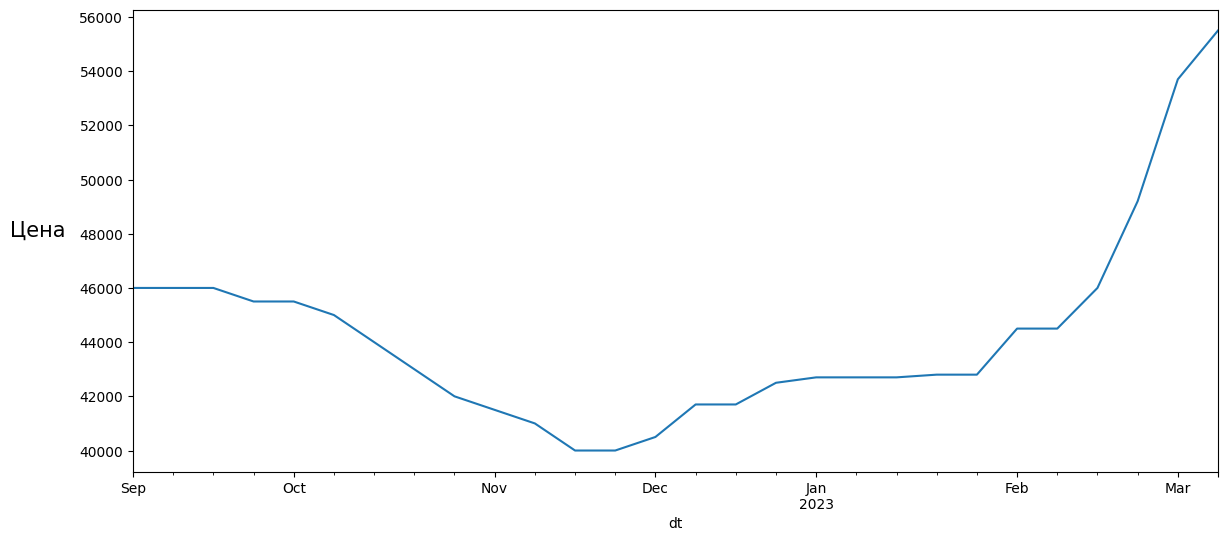

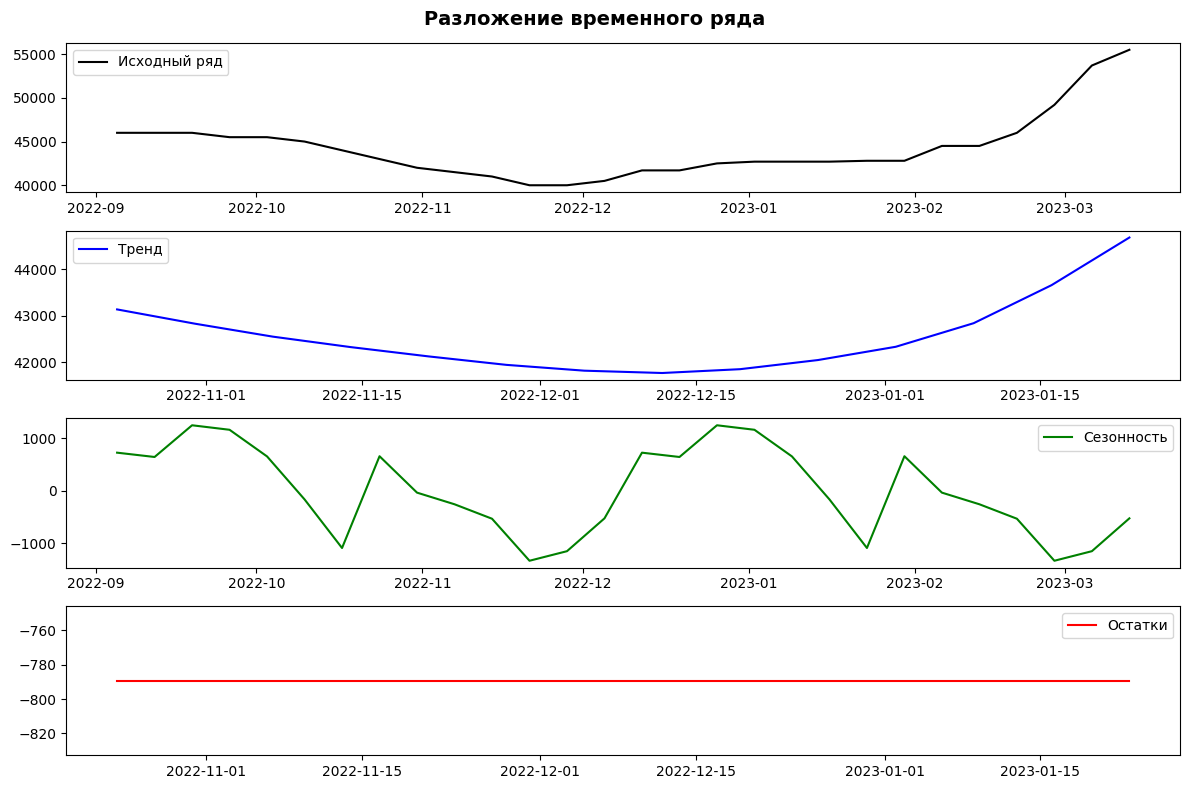

In [6]:
# Разложение временного ряда
decomposition = seasonal_decompose(test['Цена на арматуру'], model='additive', period=14)  # период ~1 год



# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
# plt.title('Time series example')
# plt.xlabel('Date', fontsize=15)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=15)
test['Цена на арматуру'].plot()

plt.figure(figsize=(12, 8))
plt.suptitle("Разложение временного ряда", fontsize=14, fontweight='bold')

plt.subplot(4, 1, 1)
plt.plot(test['Цена на арматуру'], label='Исходный ряд', color='black')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Тренд', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Остатки', color='red')
plt.legend()

plt.tight_layout()
plt.show()

Проверка стационарности

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    """
    Функция для проверки стационарности временного ряда с помощью теста Дики-Фуллера.
    
   
    """
    result = adfuller(series.dropna())  # Тест ADF, удаляем NaN перед проверкой
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {result[0]:.4f}")
    print(f"p-значение: {result[1]:.4f}")
    print("Критические значения:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    # Интерпретация результатов
    if result[1] <= 0.05:
        print("\nРяд стационарен")
    else:
        print("\nРяд НЕ стационарен")

# Проверяем стационарность исходного ряда
test_stationarity(test['Цена на арматуру'])

Результаты теста Дики-Фуллера:
ADF-статистика: 2.3872
p-значение: 0.9990
Критические значения:
   1%: -3.6996
   5%: -2.9764
   10%: -2.6276

Ряд НЕ стационарен


Решение проблемы не стационарности

In [8]:
# Определяем окно скользящего стандартного отклонения
window = 12  # Например, 12 для месячных данных

# Копируем данные, чтобы не изменять оригинальный DataFrame
df_transformed = test.copy()

# Вычисляем скользящее стандартное отклонение
df_transformed['rolling_std'] = df_transformed['Цена на арматуру'].rolling(window=window).std()

# Нормализуем ряд, деля на скользящее стандартное отклонение
df_transformed['normalized_price'] = df_transformed['Цена на арматуру'] / df_transformed['rolling_std']

# Логарифмируем нормализованный ряд (добавляем небольшую константу, чтобы избежать log(0))
df_transformed['log_normalized_price'] = np.log(df_transformed['normalized_price'] + 1e-10)

# Дифференцируем логарифмированный ряд
df_transformed['stationary_price'] = df_transformed['log_normalized_price'].diff()

# Удаляем пропущенные значения, возникшие после вычислений
df_transformed = df_transformed.dropna()

# Выводим обработанный DataFrame
df_transformed


,Цена на арматуру,year,month,quarter,day_of_month,day_of_week,rolling_std,normalized_price,log_normalized_price,stationary_price
dt,,,,,,,,,,
2022-11-28,40000,2022,11,4,28,0,2330.219784,17.165763,2.842917,-0.057607
2022-12-05,40500,2022,12,4,5,0,2289.634085,17.688416,2.872910,0.029993
2022-12-12,41700,2022,12,4,12,0,2075.451758,20.092011,3.000322,0.127412
2022-12-19,41700,2022,12,4,19,0,1849.549495,22.546031,3.115559,0.115237
2022-12-26,42500,2022,12,4,26,0,1532.353112,27.735122,3.322700,0.207141
2023-01-02,42700,2023,1,1,2,0,1223.135563,34.910276,3.552781,0.230082
2023-01-09,42700,2023,1,1,9,0,1047.471704,40.764824,3.707820,0.155038
2023-01-16,42700,2023,1,1,16,0,1014.291811,42.098338,3.740008,0.032189
2023-01-23,42800,2023,1,1,23,0,1068.984225,40.038009,3.689829,-0.050179


In [9]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Создаем копию данных
df_stationary = df_transformed.copy()

# Применяем логарифмирование
df_stationary['log_price'] = np.log(df_transformed['Цена на арматуру'] + 1)

# Дифференцируем логарифмированную цену
df_stationary['diff_log_price'] = df_stationary['log_price'].diff()

# Удаляем NaN после дифференцирования
df_stationary.dropna(inplace=True)

# Функция для проверки стационарности
def test_stationarity(series):
    result = adfuller(series.dropna())
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Критические значения:", result[4])

# Проверяем стационарность
test_stationarity(df_stationary['diff_log_price'])

# Сохраняем преобразованный датасет
df_stationary.to_csv("test_ready.csv", index=True)


Результаты теста Дики-Фуллера:
ADF-статистика: -2.0416
p-value: 0.2687
Критические значения: {'1%': np.float64(-4.01203360058309), '5%': np.float64(-3.1041838775510207), '10%': np.float64(-2.6909873469387753)}


In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Создаем копию данных
df_stationary = df_transformed.copy()

# Применяем логарифмирование
df_stationary['log_price'] = np.log(df_transformed['Цена на арматуру'] + 1)

# Первая разность логарифмированной цены
df_stationary['diff_log_price'] = df_stationary['log_price'].diff()

# Вторая разность логарифмированной цены
df_stationary['diff2_log_price'] = df_stationary['diff_log_price'].diff()

# Удаляем NaN после дифференцирования
df_stationary.dropna(inplace=True)

# Функция для проверки стационарности
def test_stationarity(series):
    result = adfuller(series.dropna())
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Критические значения:", result[4])

# Проверяем стационарность
test_stationarity(df_stationary['diff2_log_price'])

# Сохраняем преобразованный датасет
df_stationary.to_csv("test_ready.csv", index=True)


Результаты теста Дики-Фуллера:
ADF-статистика: 0.0293
p-value: 0.9609
Критические значения: {'1%': np.float64(-4.331573), '5%': np.float64(-3.23295), '10%': np.float64(-2.7487)}


In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Создаем копию данных
df_stationary = df_transformed.copy()

# Применяем логарифмирование
df_stationary['log_price'] = np.log(df_transformed['Цена на арматуру'] + 1)

# Первая разность логарифмированной цены
df_stationary['diff_log_price'] = df_stationary['log_price'].diff()

# Вторая разность логарифмированной цены
df_stationary['diff2_log_price'] = df_stationary['diff_log_price'].diff()

# Третья разность логарифмированной цены
df_stationary['diff3_log_price'] = df_stationary['diff2_log_price'].diff()

# Удаляем NaN после дифференцирования
df_stationary.dropna(inplace=True)

# Функция для проверки стационарности
def test_stationarity(series):
    result = adfuller(series.dropna())
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Критические значения:", result[4])

# Проверяем стационарность
test_stationarity(df_stationary['diff3_log_price'])

# Сохраняем преобразованный датасет
df_stationary.to_csv("test_ready.csv", index=True)


Результаты теста Дики-Фуллера:
ADF-статистика: -5.4644
p-value: 0.0000
Критические значения: {'1%': np.float64(-4.331573), '5%': np.float64(-3.23295), '10%': np.float64(-2.7487)}


In [12]:
test_ready = pd.read_csv("test_ready.csv")

In [ ]:
import pandas as pd

# Загружаем данные
train_ready = pd.read_csv("train_ready.csv")
test_ready = pd.read_csv("test_ready.csv")

# --- 1. Проверка совпадения колонок ---
train_columns = set(train_ready.columns)
test_columns = set(test_ready.columns)

missing_in_test = train_columns - test_columns
missing_in_train = test_columns - train_columns

print("Колонки, отсутствующие в test_ready:", missing_in_test)
print("Колонки, отсутствующие в train_ready:", missing_in_train)

# --- 2. Проверка типов данных ---
print("\nТипы данных в train_ready:")
print(train_ready.dtypes)

print("\nТипы данных в test_ready:")
print(test_ready.dtypes)

# --- 3. Проверка основных статистик ---
print("\nОписательная статистика train_ready:")
print(train_ready.describe())

print("\nОписательная статистика test_ready:")
print(test_ready.describe())

# --- 4. Проверка пропущенных значений ---
print("\nПропущенные значения в train_ready:")
print(train_ready.isnull().sum())   

print("\nПропущенные значения в test_ready:")
print(test_ready.isnull().sum())

Колонки, отсутствующие в test_ready: {'boxcox_price', 'diff_boxcox_price'}
Колонки, отсутствующие в train_ready: {'log_price', 'diff3_log_price', 'diff_log_price', 'diff2_log_price'}

Типы данных в train_ready:
dt                       object
Цена на арматуру          int64
year                      int64
month                     int64
quarter                   int64
day_of_month              int64
day_of_week               int64
rolling_std             float64
normalized_price        float64
log_normalized_price    float64
stationary_price        float64
boxcox_price            float64
diff_boxcox_price       float64
dtype: object

Типы данных в test_ready:
dt                       object
Цена на арматуру          int64
year                      int64
month                     int64
quarter                   int64
day_of_month              int64
day_of_week               int64
rolling_std             float64
normalized_price        float64
log_normalized_price    float64
stationary_p

In [ ]:
import pickle
import pandas as pd

# Пути к файлам
model_path = "lightgbm_model.pkl"
test_data_path = "test_ready_fixed.csv"

# Загрузка модели
with open(model_path, "rb") as file:
    model = pickle.load(file)

# Загрузка тестовых данных
test_data = pd.read_csv(test_data_path)

# Вывод первых строк данных для проверки
test_data.head()


FileNotFoundError: [Errno 2] No such file or directory: 'test_ready_fixed.csv'

In [ ]:
print(f"Признаки модели ({len(model_features)}): {sorted(model_features)}")
print(f"Признаки теста ({len(features.columns)}): {sorted(features.columns)}")


In [ ]:
import pandas as pd
import pickle

# Загружаем test_ready_fixed.csv
test_data = pd.read_csv("test_ready_fixed.csv")

# Преобразуем dt в datetime
test_data["dt"] = pd.to_datetime(test_data["dt"], errors="coerce")

# Извлекаем числовые признаки из даты
test_data["year"] = test_data["dt"].dt.year
test_data["month"] = test_data["dt"].dt.month
test_data["day"] = test_data["dt"].dt.day
test_data["day_of_week"] = test_data["dt"].dt.weekday

# Удаляем ненужные колонки (например, саму дату и целевую переменную)
features = test_data.drop(columns=["Цена на арматуру", "dt"], errors="ignore")

# Загружаем модель
with open("lightgbm_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

# Получаем список признаков, на которых обучалась модель
model_features = set(model.feature_name())

# Оставляем только совпадающие признаки
common_features = list(model_features & set(features.columns))
features = features[common_features]

# Делаем предсказание
predictions = model.predict(features)

# Добавляем предсказания в DataFrame
test_data["predicted_price"] = predictions

# Сохраняем результат в CSV
output_path = "test_predictions.csv"
test_data.to_csv(output_path, index=False)

# Выводим информацию
print(f"Используемые признаки: {common_features}")
print(f"Результат сохранен в: {output_path}")


In [ ]:
from scipy.stats import boxcox

# Загружаем test_ready
test_ready = pd.read_csv("test_ready.csv")

# Вычисляем Box-Cox и его разности
test_ready["boxcox_price"], lambda_bc = boxcox(test_ready["Цена на арматуру"] + 1)
test_ready["diff_boxcox_price"] = test_ready["boxcox_price"].diff()

# Удаляем NaN после дифференцирования
test_ready.dropna(inplace=True)

# Сохраняем обновленный файл
test_ready.to_csv("test_ready_fixed.csv", index=False)


In [ ]:
import pandas as pd

# Загружаем обновленные данные
train_ready = pd.read_csv("train_ready.csv")
test_ready = pd.read_csv("test_ready_fixed.csv")

# 1. Сравним структуру данных
train_columns = set(train_ready.columns)
test_columns = set(test_ready.columns)

# Колонки, которые есть в train, но нет в test
missing_in_test = train_columns - test_columns
# Колонки, которые есть в test, но нет в train
missing_in_train = test_columns - train_columns

print(f"Колонки, отсутствующие в test_ready: {missing_in_test}")
print(f"Колонки, отсутствующие в train_ready: {missing_in_train}")

# 2. Проверим типы данных
print("\nТипы данных в train_ready:")
print(train_ready.dtypes)

print("\nТипы данных в test_ready:")
print(test_ready.dtypes)

# 3. Проверим основные статистические параметры
print("\nСтатистика train_ready:")
print(train_ready.describe())

print("\nСтатистика test_ready:")
print(test_ready.describe())

# 4. Проверим пропущенные значения
print("\nПропущенные значения в train_ready:")
print(train_ready.isnull().sum())

print("\nПропущенные значения в test_ready:")
print(test_ready.isnull().sum())


Модель SARIMA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Разложение на тренд и сезонность
decomposition = seasonal_decompose(test_ready['Цена на арматуру'], model='additive', period=52)
test_ready['trend'] = decomposition.trend
test_ready['seasonal'] = decomposition.seasonal

# Заполнение пропусков
for col in ['trend', 'seasonal']:
    test_ready[col] = test_ready[col].interpolate()

# Разделение данных на train и test
test_size = int(len(test_ready) * 0.8)
test_ready, test = test_ready.iloc[:test_size], test_ready.iloc[test_size:]

# Обучение модели SARIMA
model = SARIMAX(test_ready['Цена на арматуру'], order=(2,1,2), seasonal_order=(1,1,1,52))
model_fit = model.fit(disp=False)

# Прогнозирование
predictions = model_fit.predict(start=len(test_ready), end=len(test_ready) + len(test) - 1, dynamic=False)

# Оценка точности
mae = mean_absolute_error(test['Цена на арматуру'], predictions)
mse = mean_squared_error(test['Цена на арматуру'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['Цена на арматуру'], predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(test_ready.index, test_ready['Цена на арматуру'], label='Train', color='green')
plt.plot(test.index, test['Цена на арматуру'], label='Test', color='blue')
plt.plot(test.index, predictions, label='Forecast', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (SARIMA)')
plt.legend()
plt.show()


In [ ]:
!pip install lightgbm
!pip install optuna
import lightgbm as lgb
import optuna

Модель LightGBM №1

In [ ]:
df = pd.read_csv("train_ready.csv", parse_dates=['dt'])

# Обработка стационарности (разложение на тренд и сезонность)
decomposition = seasonal_decompose(df['Цена на арматуру'], model='additive', period=52)
df['trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal

# Заполнение пропусков
df['trend'].interpolate(inplace=True)
df['seasonal'].interpolate(inplace=True)

# Количество временных лагов
lag_features = 12

for i in range(1, lag_features + 1):
    df[f"lag_{i}"] = df["Цена на арматуру"].shift(i)

df.dropna(inplace=True)  # Убираем пропущенные значения

# Выбираем целевую переменную и признаки
target_col = "Цена на арматуру"
feature_cols = [col for col in df.columns if col not in ["dt", target_col]]

# Разделяем данные на train/test
train_size = 0.9
train_df, test_df = train_test_split(df, test_size=1-train_size, shuffle=False)

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# Создаём датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 50),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'feature_pre_filter': False,
        'verbose': -1
    }

    model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(50)])

    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

# Запуск Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение финальной модели
best_params["verbose"] = -1
final_model = lgb.train(best_params, train_data, num_boost_round=500, valid_sets=[test_data],
                        callbacks=[lgb.early_stopping(50)])

# Прогноз
final_predictions = final_model.predict(X_test)

# Оценка точности
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, final_predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, y_train, label='Train', color='green')
plt.plot(test_df.index, y_test, label='Test', color='blue')
plt.plot(test_df.index, final_predictions, label='Forecast', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (LightGBM)')
plt.legend()
plt.show()


Добавление фичей

In [ ]:
df['rolling_mean_3'] = df["Цена на арматуру"].rolling(window=3).mean()
df['rolling_mean_6'] = df["Цена на арматуру"].rolling(window=6).mean()
df['rolling_mean_12'] = df["Цена на арматуру"].rolling(window=12).mean()

df['price_diff_1'] = df["Цена на арматуру"].diff(1)
df['price_diff_3'] = df["Цена на арматуру"].diff(3)

df['ewm_6'] = df["Цена на арматуру"].ewm(span=6, adjust=False).mean()
df['ewm_12'] = df["Цена на арматуру"].ewm(span=12, adjust=False).mean()

df.fillna(0, inplace=True)

print(df.head())

In [ ]:
features = [
    "rolling_mean_3", "rolling_mean_6", "rolling_mean_12",
    "price_diff_1", "price_diff_3", "ewm_6", "ewm_12"
]

target = "Цена на арматуру"

X = df[features]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)


Матрица корреляции

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция признаков")
plt.show()


Модель LightGBM №2

In [ ]:
df = pd.read_csv("train_ready.csv", parse_dates=['dt'])

# Количество временных лагов
lag_features = 12
for i in range(1, lag_features + 1):
    df[f"lag_{i}"] = df["Цена на арматуру"].shift(i)

# Добавляем скользящие средние
df["rolling_mean_3"] = df["Цена на арматуру"].rolling(3).mean()
df["rolling_mean_6"] = df["Цена на арматуру"].rolling(6).mean()
df["rolling_mean_12"] = df["Цена на арматуру"].rolling(12).mean()

# Добавляем экспоненциальное сглаживание
df["ewm_6"] = df["Цена на арматуру"].ewm(span=6).mean()
df["ewm_12"] = df["Цена на арматуру"].ewm(span=12).mean()

# Добавляем разности цен
df["diff_1"] = df["Цена на арматуру"].diff(1)
df["diff_3"] = df["Цена на арматуру"].diff(3)

df = df.dropna()  

# Выбираем целевую переменную и признаки
target_col = "Цена на арматуру"
feature_cols = [col for col in df.columns if col not in ["dt", target_col]]

# Разделяем данные на train/test
train_size = 0.9  # 90% данных на обучение
train_df, test_df = train_test_split(df, test_size=1-train_size, shuffle=False)

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# Создаём датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 50),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'feature_pre_filter': False,
        'verbose': -1
    }

    model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(50)])
    
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

# Запуск Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение финальной модели с лучшими параметрами
best_params["verbose"] = -1
final_model = lgb.train(best_params, train_data, num_boost_round=500, valid_sets=[test_data],
                        callbacks=[lgb.early_stopping(50)])

# Прогнозируем
final_predictions = final_model.predict(X_test)

# Оценка точности
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, final_predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация прогнозов
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label='Фактические цены', color='blue')
plt.plot(test_df.index, final_predictions, label='Прогноз LightGBM', color='red', linestyle='--')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цен на арматуру с использованием LightGBM")
plt.legend()
plt.show()

In [ ]:
# Вычисляем MAPE
mape = np.mean(np.abs((y_test - final_predictions) / y_test)) * 100

# Вычисляем точность модели
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Точность модели: {accuracy:.2f}%")


In [ ]:
import pickle

# Сохранение модели
model_filename = "lightgbm_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(final_model, file)

print(f"Модель сохранена в {model_filename}")
